# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [1]:
# Adcionado pelo UV
#! pip install Pillow

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [3]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [4]:
!ls MNIST

processed  raw


In [5]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


/tmp/ipykernel_17235/482652978.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [6]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(np.float64(-0.5), np.float64(232.5), np.float64(87.5), np.float64(-0.5))

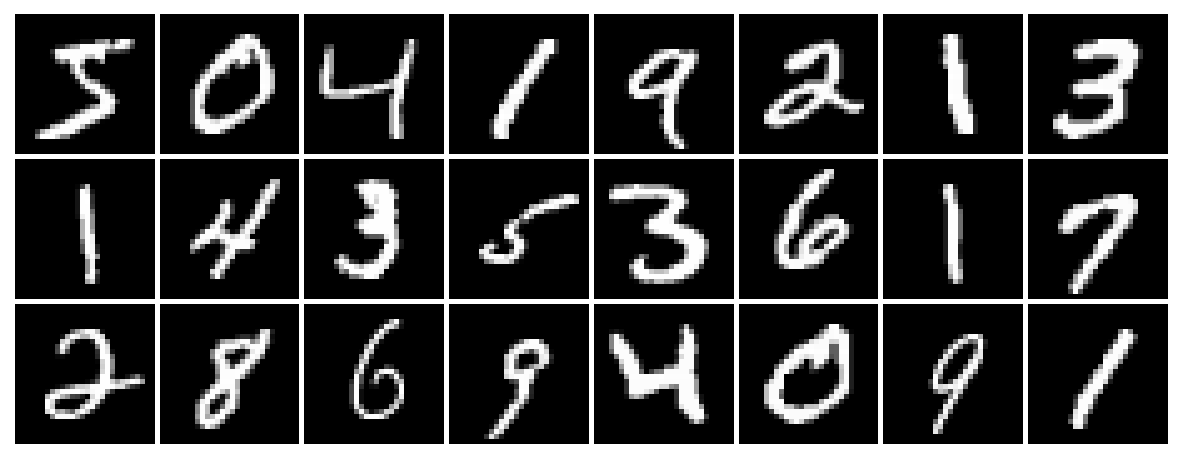

In [7]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


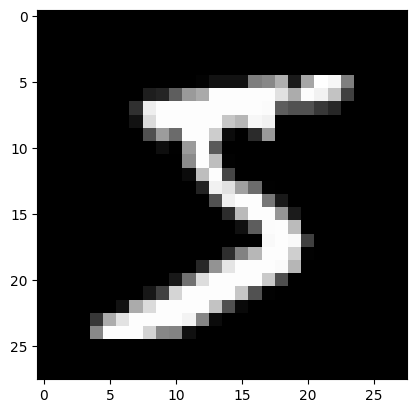

In [8]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [9]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [10]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[-0.2103,  0.2498,  0.0827, -0.1688,  0.0648,  0.0567, -0.3422, -0.1159,
          0.0240, -0.3276],
        [-0.2327,  0.1049,  0.0556, -0.1442,  0.1984,  0.2749, -0.4596, -0.0082,
         -0.1614, -0.4629],
        [-0.2018,  0.2720, -0.1346, -0.1146, -0.0680, -0.0352, -0.1903,  0.0101,
          0.1869, -0.0878],
        [-0.2833, -0.0157,  0.0372,  0.0547, -0.2703,  0.0100, -0.2066,  0.2895,
         -0.4479, -0.1926],
        [-0.3451,  0.4212,  0.0750,  0.1272,  0.1084,  0.1440, -0.3713,  0.1558,
          0.0475,  0.1785]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [11]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [12]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

zsh:1: command not found: pip
zsh:1: command not found: pip


In [13]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3153, grad_fn=<NllLossBackward0>)

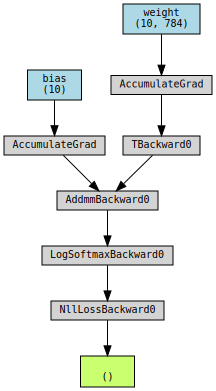

In [14]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [15]:
import numpy
losses = []
zs = []
train_metrics = []
for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    train_metrics.append(
        {
            'epoch': i+1,
            'loss': loss.item(),
            'accuracy': accuracy,
            'weights': model.state_dict()['weight'].numpy().copy(),
            'bias': model.state_dict()['bias'].numpy().copy()
        }
    )


In [16]:
print('Final loss:', loss.item())

Final loss: 0.26517578959465027


### Visualizando gráfico de perda durante o treinamento

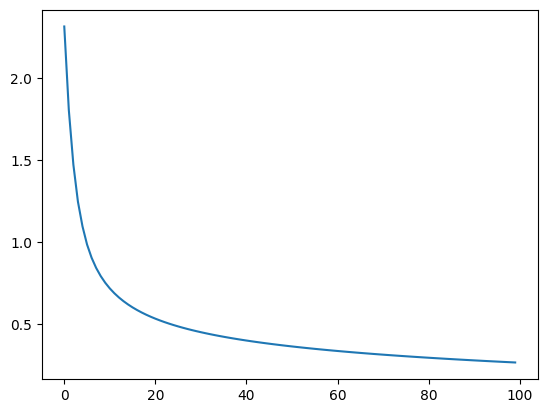

In [17]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [18]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.94


### Matriz de confusão com dados de treinamento e teste

In [19]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,1,0,0,0,2,2,1,0
2,0,1,91,1,0,1,0,1,2,1
3,0,0,0,88,0,2,0,0,0,0
4,0,0,1,0,102,2,1,2,0,3
5,0,2,0,1,0,81,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,1,1,0,0,0,111,0,4
8,0,2,2,0,0,2,0,0,82,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


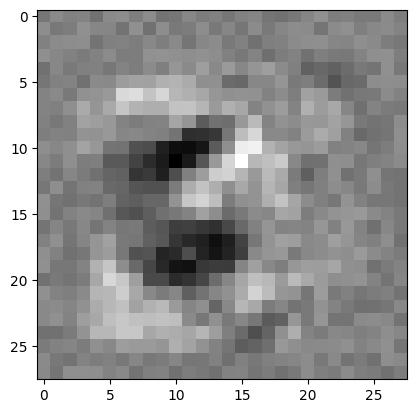

In [20]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

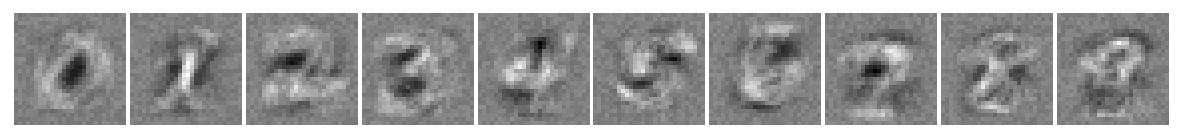

In [21]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [22]:
qtd_epochs = len(train_metrics)
for epoch in train_metrics:
        print(f"Época {epoch.get('epoch')}/{qtd_epochs} - Perda: {epoch.get('loss'):.4f} - Acurácia: {epoch.get('accuracy'):.4f}")


Época 1/100 - Perda: 2.3153 - Acurácia: 0.1260
Época 2/100 - Perda: 1.8056 - Acurácia: 0.6150
Época 3/100 - Perda: 1.4721 - Acurácia: 0.7570
Época 4/100 - Perda: 1.2463 - Acurácia: 0.7760
Época 5/100 - Perda: 1.0958 - Acurácia: 0.8200
Época 6/100 - Perda: 0.9851 - Acurácia: 0.8180
Época 7/100 - Perda: 0.9043 - Acurácia: 0.8440
Época 8/100 - Perda: 0.8421 - Acurácia: 0.8450
Época 9/100 - Perda: 0.7924 - Acurácia: 0.8540
Época 10/100 - Perda: 0.7515 - Acurácia: 0.8580
Época 11/100 - Perda: 0.7170 - Acurácia: 0.8640
Época 12/100 - Perda: 0.6875 - Acurácia: 0.8650
Época 13/100 - Perda: 0.6619 - Acurácia: 0.8700
Época 14/100 - Perda: 0.6393 - Acurácia: 0.8700
Época 15/100 - Perda: 0.6192 - Acurácia: 0.8730
Época 16/100 - Perda: 0.6012 - Acurácia: 0.8740
Época 17/100 - Perda: 0.5849 - Acurácia: 0.8750
Época 18/100 - Perda: 0.5701 - Acurácia: 0.8780
Época 19/100 - Perda: 0.5565 - Acurácia: 0.8810
Época 20/100 - Perda: 0.5440 - Acurácia: 0.8820
Época 21/100 - Perda: 0.5325 - Acurácia: 0.8820
É

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

Época 1/100 - Perda: 2.3153 - Acurácia: 0.1260
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


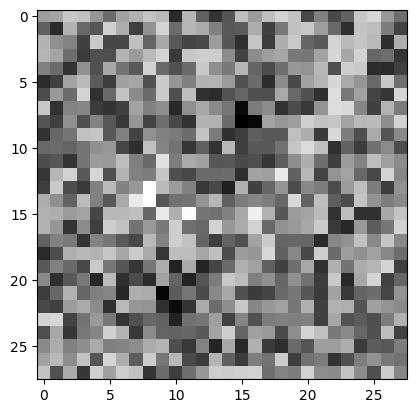

Época 2/100 - Perda: 1.8056 - Acurácia: 0.6150
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


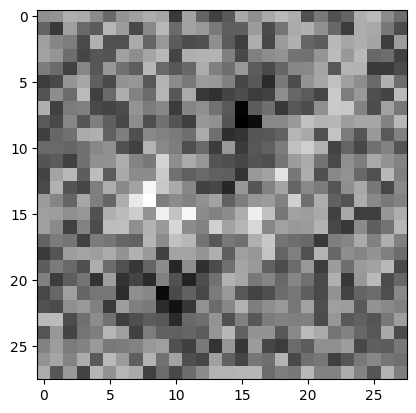

Época 3/100 - Perda: 1.4721 - Acurácia: 0.7570
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


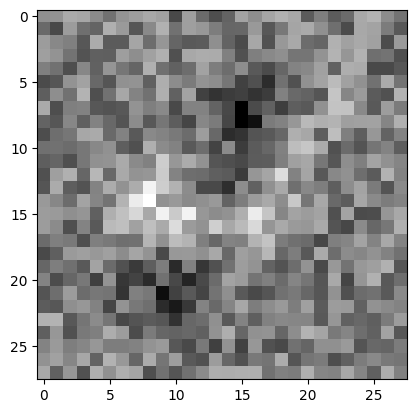

Época 4/100 - Perda: 1.2463 - Acurácia: 0.7760
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


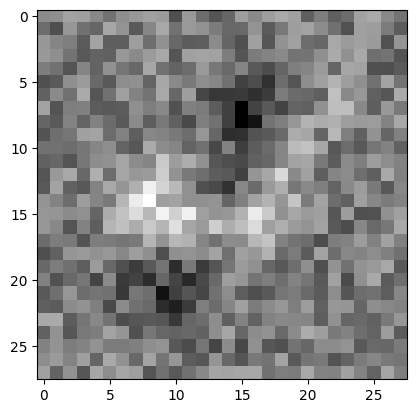

Época 5/100 - Perda: 1.0958 - Acurácia: 0.8200
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


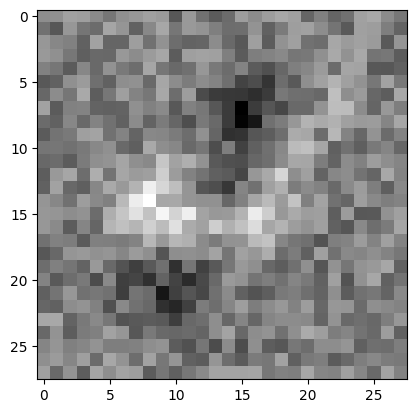

Época 6/100 - Perda: 0.9851 - Acurácia: 0.8180
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


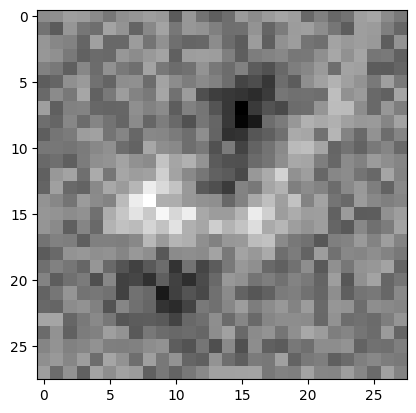

Época 7/100 - Perda: 0.9043 - Acurácia: 0.8440
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


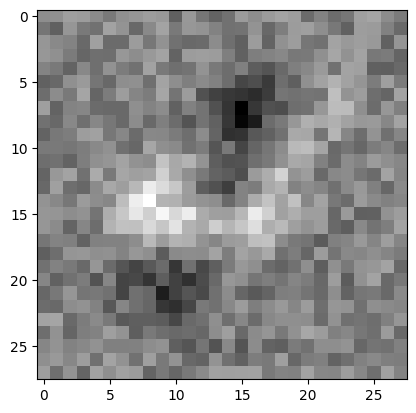

Época 8/100 - Perda: 0.8421 - Acurácia: 0.8450
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


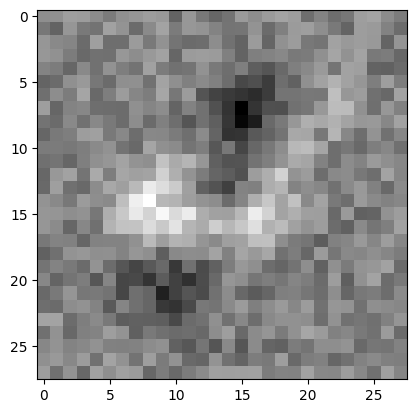

Época 9/100 - Perda: 0.7924 - Acurácia: 0.8540
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


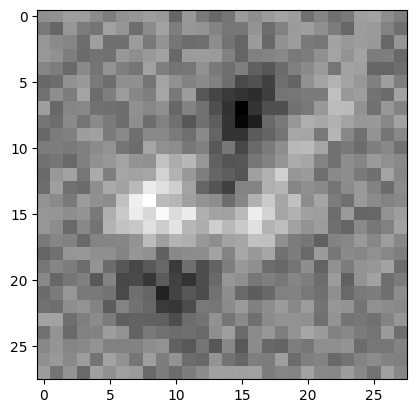

Época 10/100 - Perda: 0.7515 - Acurácia: 0.8580
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


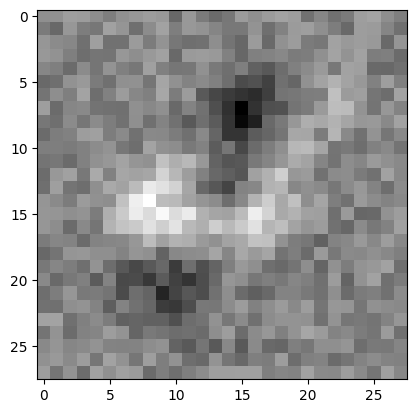

Época 11/100 - Perda: 0.7170 - Acurácia: 0.8640
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


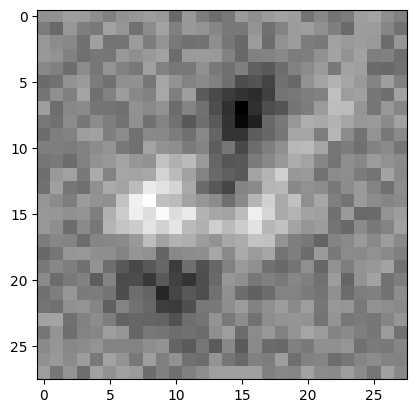

Época 12/100 - Perda: 0.6875 - Acurácia: 0.8650
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


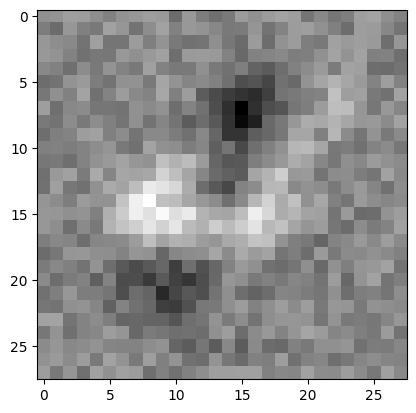

Época 13/100 - Perda: 0.6619 - Acurácia: 0.8700
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


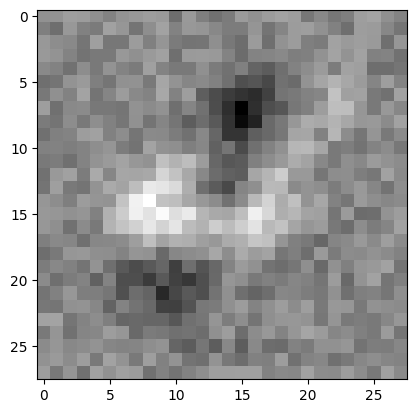

Época 14/100 - Perda: 0.6393 - Acurácia: 0.8700
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


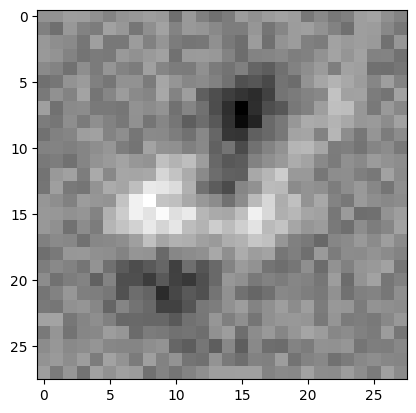

Época 15/100 - Perda: 0.6192 - Acurácia: 0.8730
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


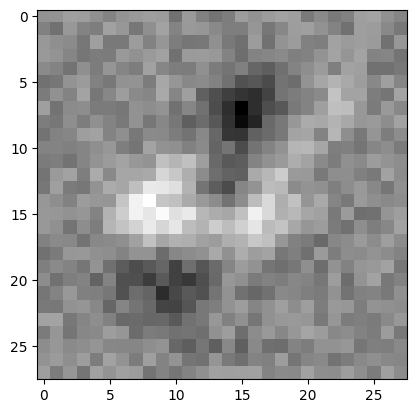

Época 16/100 - Perda: 0.6012 - Acurácia: 0.8740
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


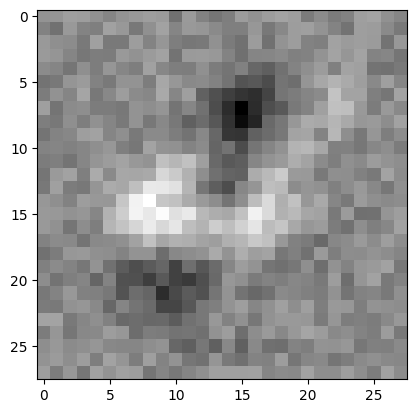

Época 17/100 - Perda: 0.5849 - Acurácia: 0.8750
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


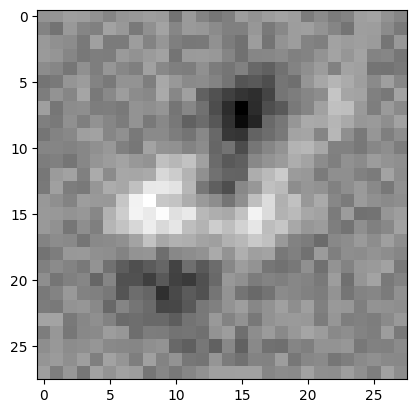

Época 18/100 - Perda: 0.5701 - Acurácia: 0.8780
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


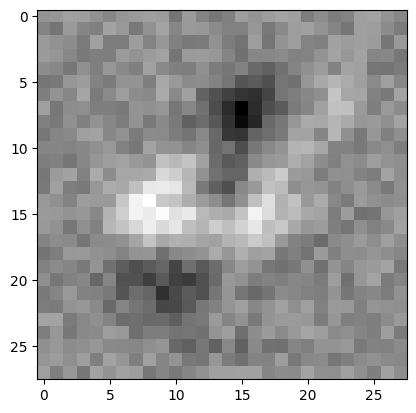

Época 19/100 - Perda: 0.5565 - Acurácia: 0.8810
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


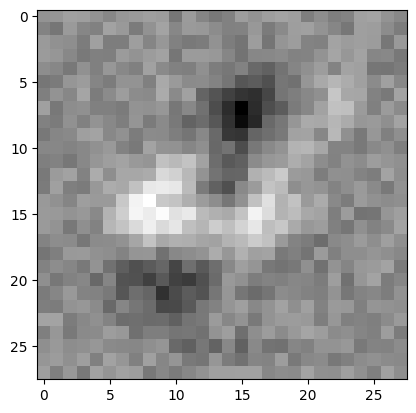

Época 20/100 - Perda: 0.5440 - Acurácia: 0.8820
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


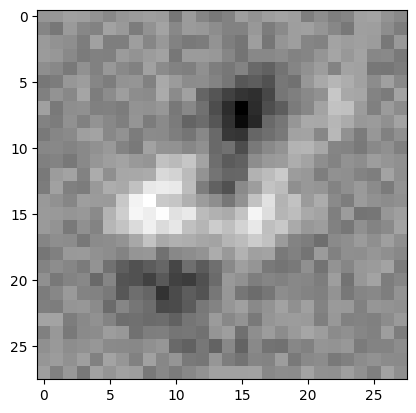

Época 21/100 - Perda: 0.5325 - Acurácia: 0.8820
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


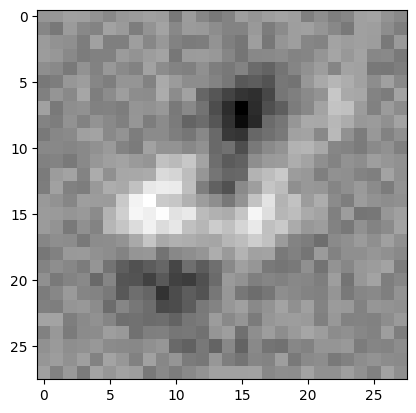

Época 22/100 - Perda: 0.5217 - Acurácia: 0.8840
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


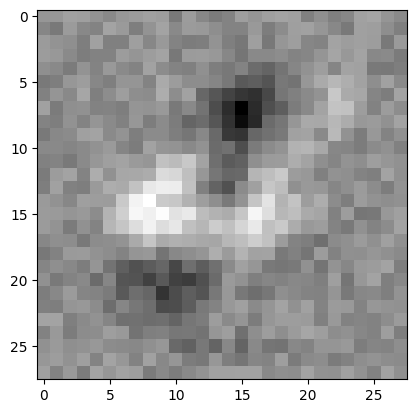

Época 23/100 - Perda: 0.5117 - Acurácia: 0.8860
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


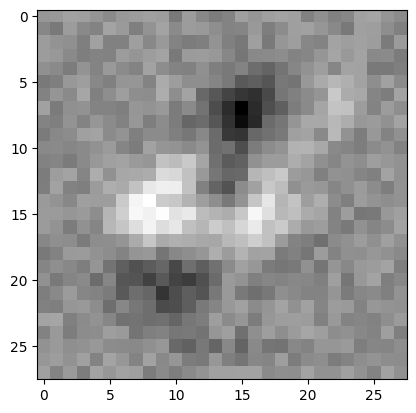

Época 24/100 - Perda: 0.5023 - Acurácia: 0.8890
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


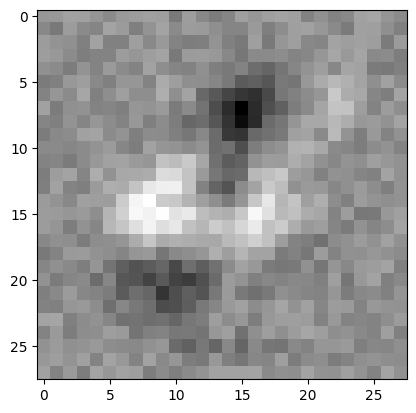

Época 25/100 - Perda: 0.4935 - Acurácia: 0.8920
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


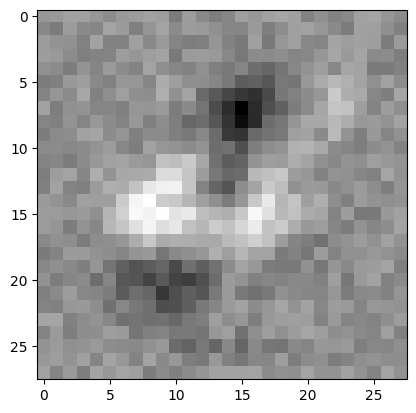

Época 26/100 - Perda: 0.4852 - Acurácia: 0.8930
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


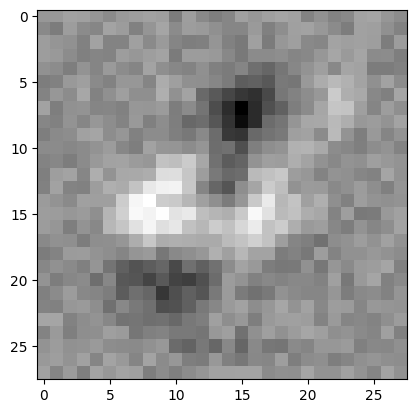

Época 27/100 - Perda: 0.4774 - Acurácia: 0.8920
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


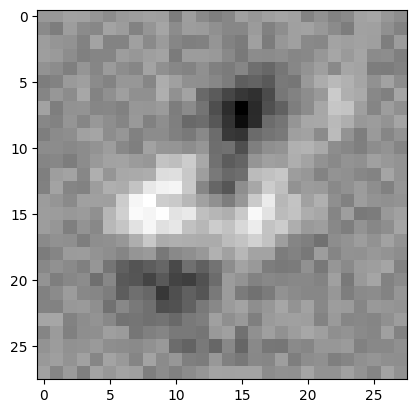

Época 28/100 - Perda: 0.4700 - Acurácia: 0.8920
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


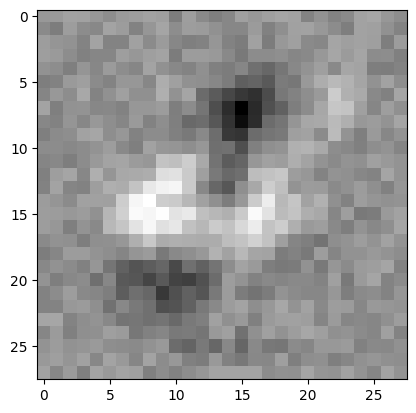

Época 29/100 - Perda: 0.4629 - Acurácia: 0.8960
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


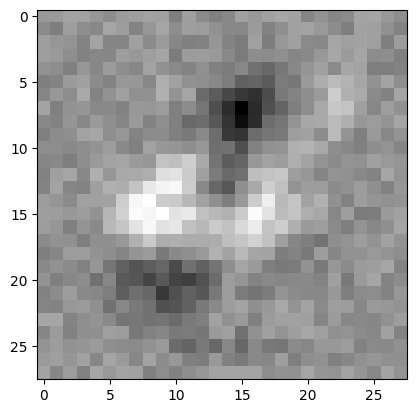

Época 30/100 - Perda: 0.4563 - Acurácia: 0.8970
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


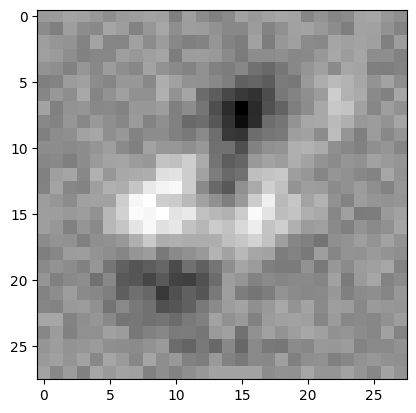

Época 31/100 - Perda: 0.4499 - Acurácia: 0.8980
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


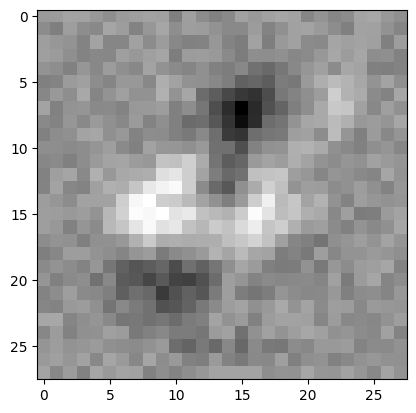

Época 32/100 - Perda: 0.4438 - Acurácia: 0.9000
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


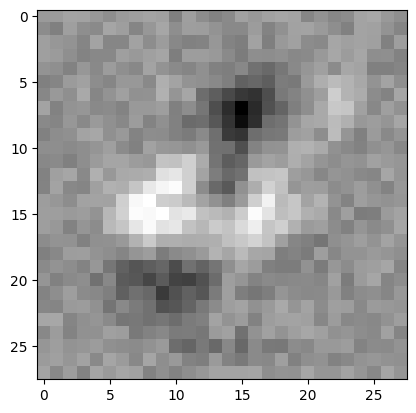

Época 33/100 - Perda: 0.4380 - Acurácia: 0.9010
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


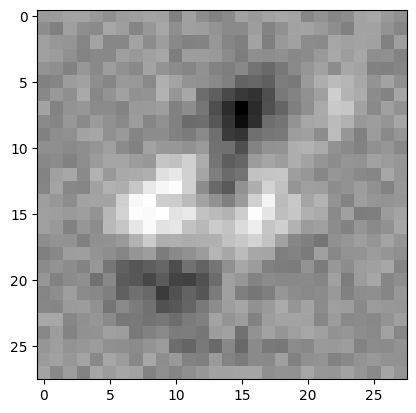

Época 34/100 - Perda: 0.4324 - Acurácia: 0.9040
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


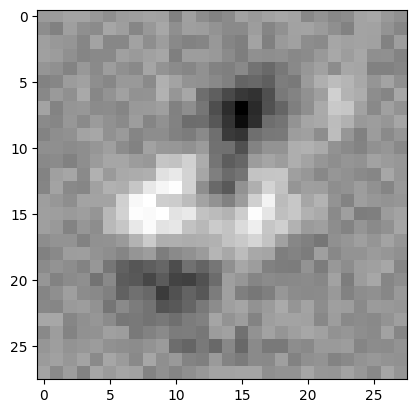

Época 35/100 - Perda: 0.4271 - Acurácia: 0.9050
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


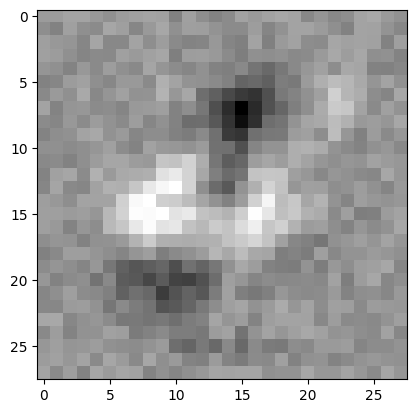

Época 36/100 - Perda: 0.4220 - Acurácia: 0.9080
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


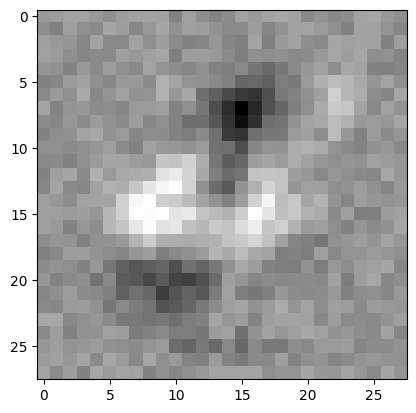

Época 37/100 - Perda: 0.4171 - Acurácia: 0.9080
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


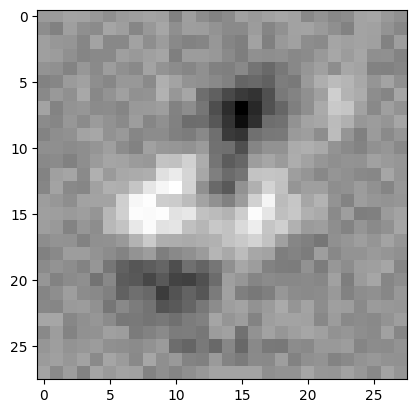

Época 38/100 - Perda: 0.4123 - Acurácia: 0.9080
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


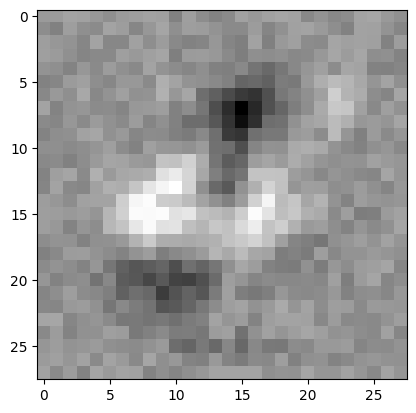

Época 39/100 - Perda: 0.4077 - Acurácia: 0.9080
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


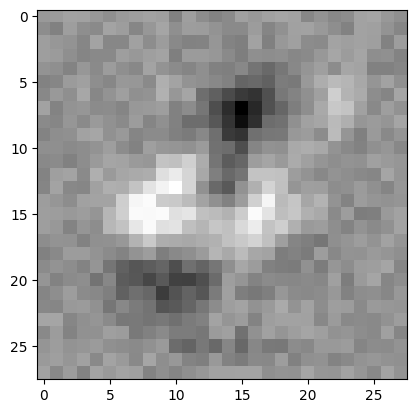

Época 40/100 - Perda: 0.4033 - Acurácia: 0.9090
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


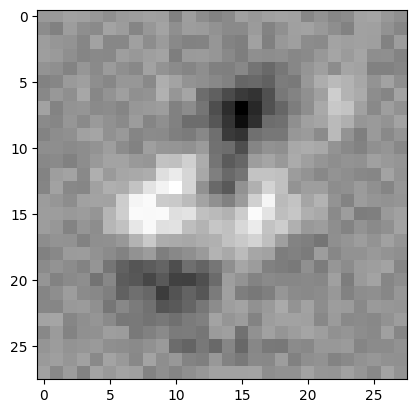

Época 41/100 - Perda: 0.3991 - Acurácia: 0.9100
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


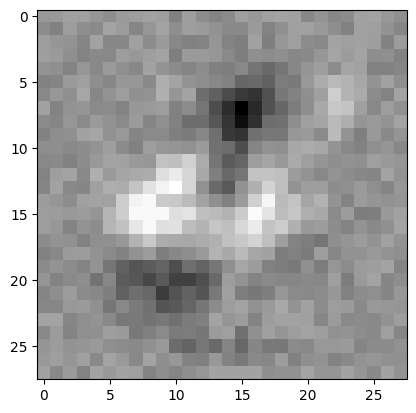

Época 42/100 - Perda: 0.3950 - Acurácia: 0.9100
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


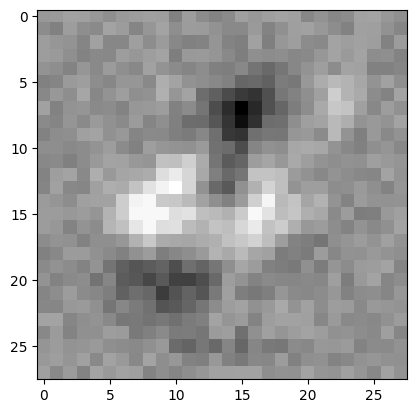

Época 43/100 - Perda: 0.3910 - Acurácia: 0.9120
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


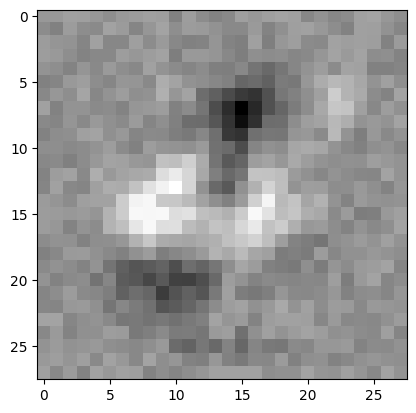

Época 44/100 - Perda: 0.3871 - Acurácia: 0.9120
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


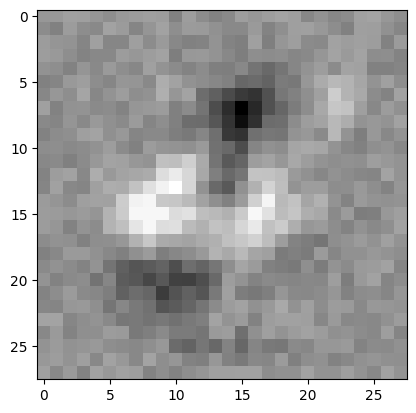

Época 45/100 - Perda: 0.3834 - Acurácia: 0.9130
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


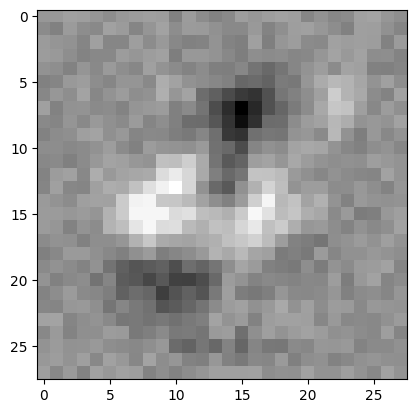

Época 46/100 - Perda: 0.3797 - Acurácia: 0.9140
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


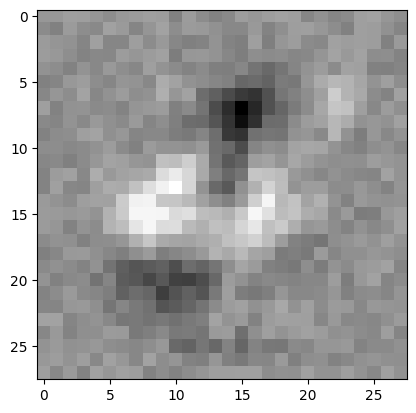

Época 47/100 - Perda: 0.3762 - Acurácia: 0.9150
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


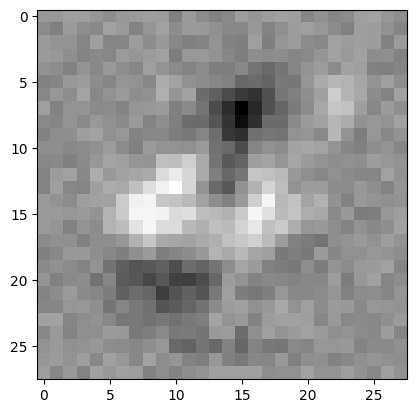

Época 48/100 - Perda: 0.3728 - Acurácia: 0.9160
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


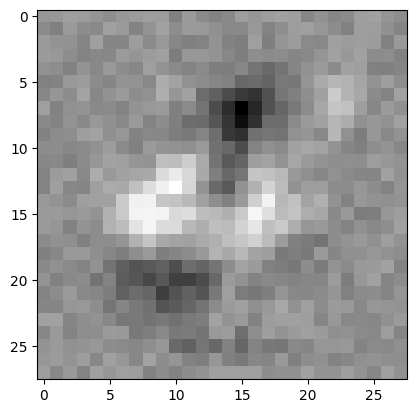

Época 49/100 - Perda: 0.3694 - Acurácia: 0.9160
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


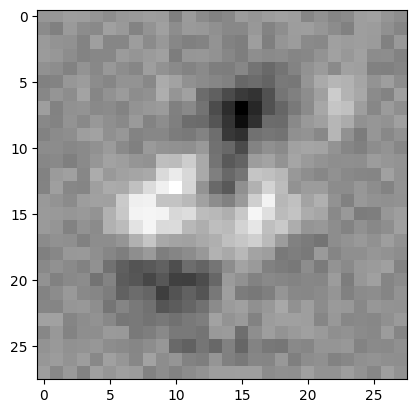

Época 50/100 - Perda: 0.3662 - Acurácia: 0.9180
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


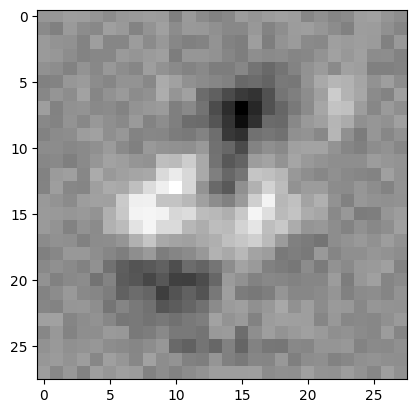

Época 51/100 - Perda: 0.3630 - Acurácia: 0.9180
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


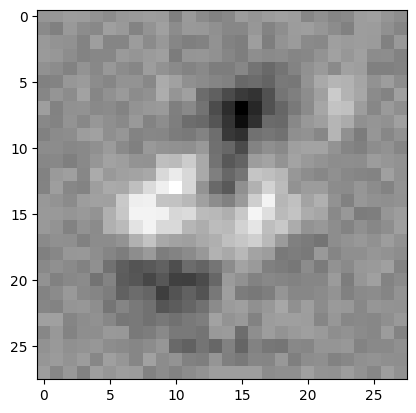

Época 52/100 - Perda: 0.3599 - Acurácia: 0.9180
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


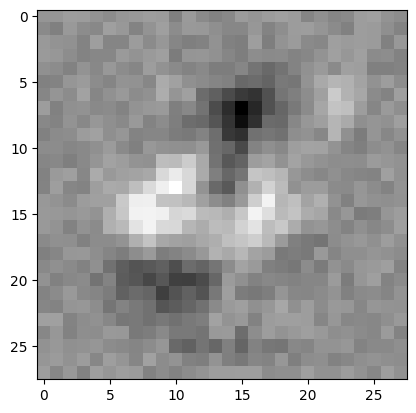

Época 53/100 - Perda: 0.3569 - Acurácia: 0.9190
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


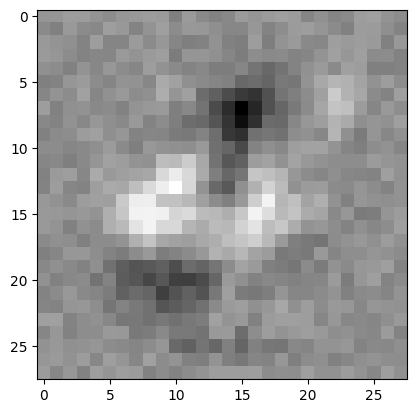

Época 54/100 - Perda: 0.3540 - Acurácia: 0.9200
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


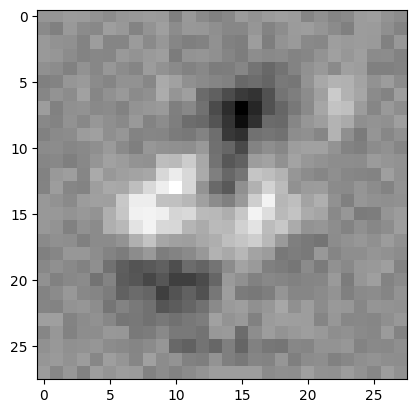

Época 55/100 - Perda: 0.3511 - Acurácia: 0.9190
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


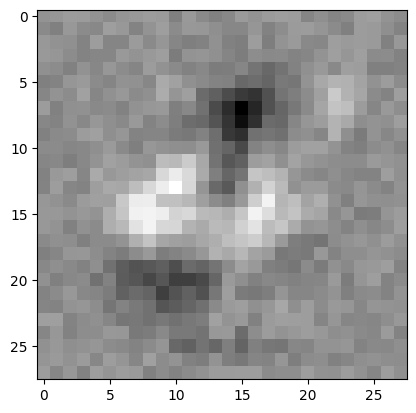

Época 56/100 - Perda: 0.3483 - Acurácia: 0.9190
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


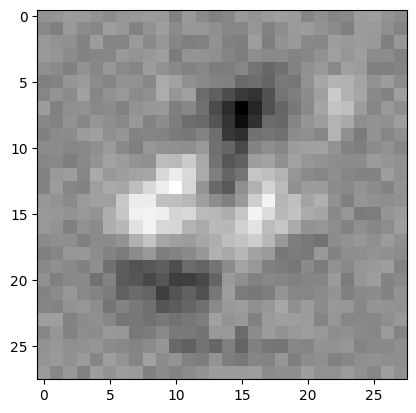

Época 57/100 - Perda: 0.3456 - Acurácia: 0.9200
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


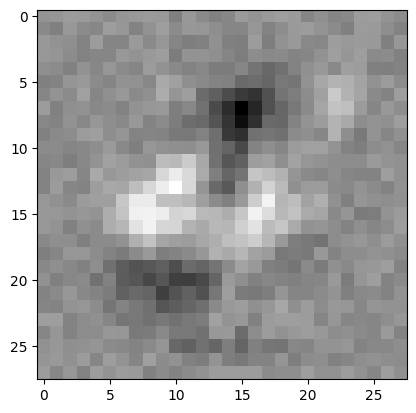

Época 58/100 - Perda: 0.3429 - Acurácia: 0.9200
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


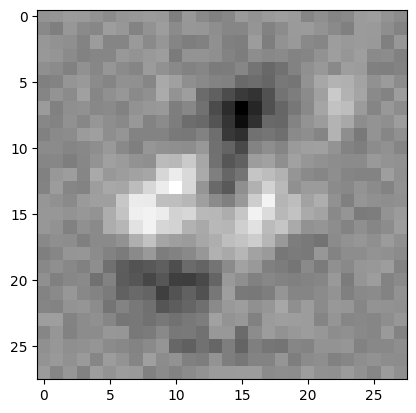

Época 59/100 - Perda: 0.3403 - Acurácia: 0.9210
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


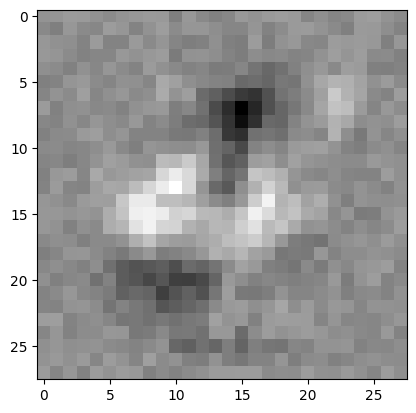

Época 60/100 - Perda: 0.3378 - Acurácia: 0.9210
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


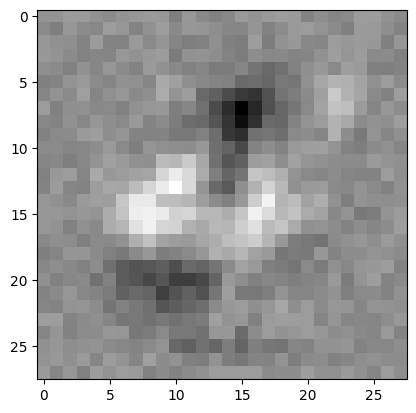

Época 61/100 - Perda: 0.3353 - Acurácia: 0.9230
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


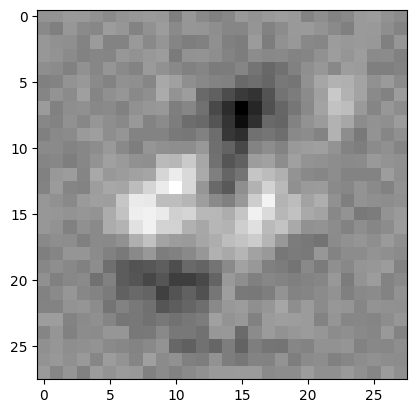

Época 62/100 - Perda: 0.3328 - Acurácia: 0.9230
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


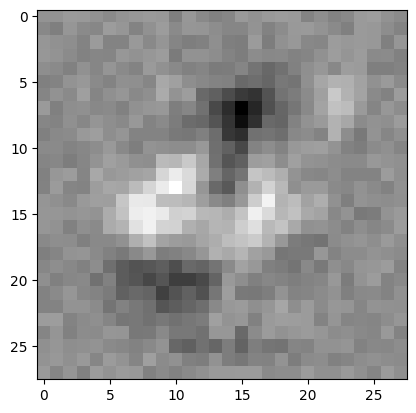

Época 63/100 - Perda: 0.3304 - Acurácia: 0.9240
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


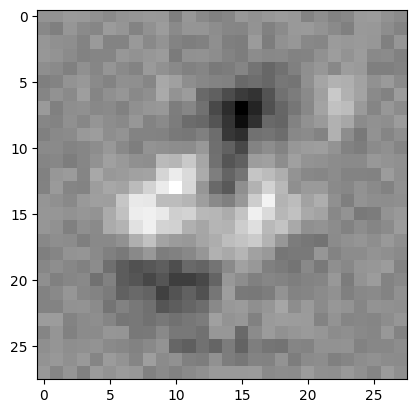

Época 64/100 - Perda: 0.3281 - Acurácia: 0.9250
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


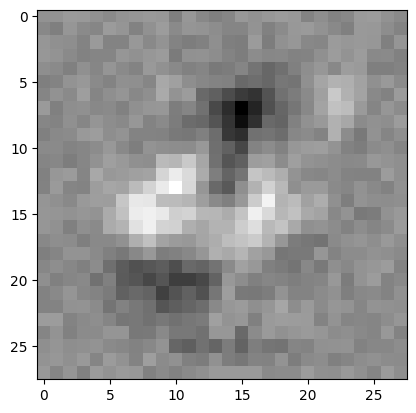

Época 65/100 - Perda: 0.3258 - Acurácia: 0.9250
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


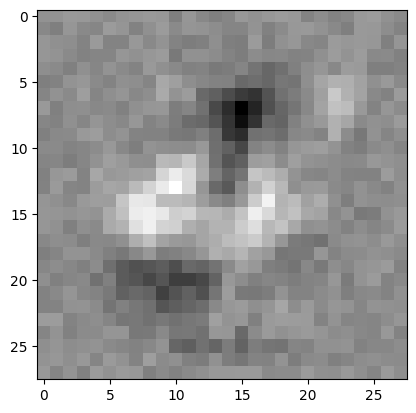

Época 66/100 - Perda: 0.3235 - Acurácia: 0.9250
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


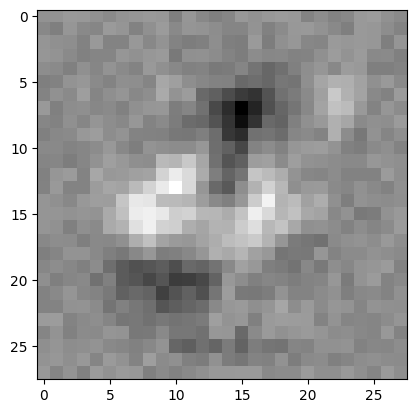

Época 67/100 - Perda: 0.3213 - Acurácia: 0.9250
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


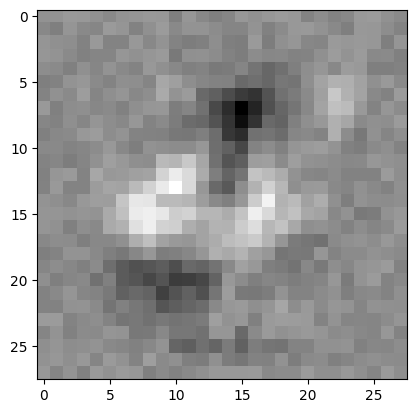

Época 68/100 - Perda: 0.3191 - Acurácia: 0.9250
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


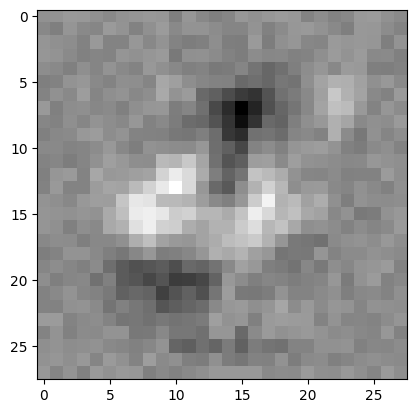

Época 69/100 - Perda: 0.3170 - Acurácia: 0.9270
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


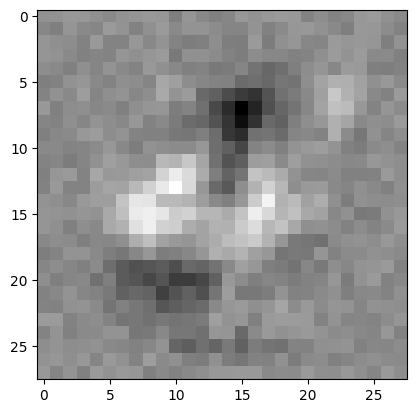

Época 70/100 - Perda: 0.3149 - Acurácia: 0.9280
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


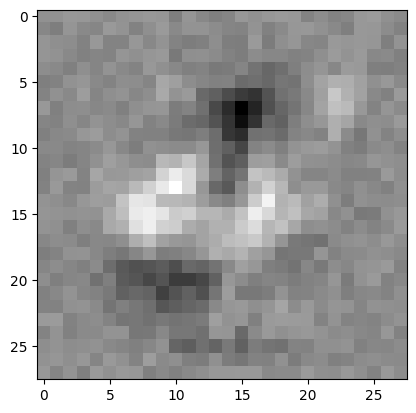

Época 71/100 - Perda: 0.3129 - Acurácia: 0.9270
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


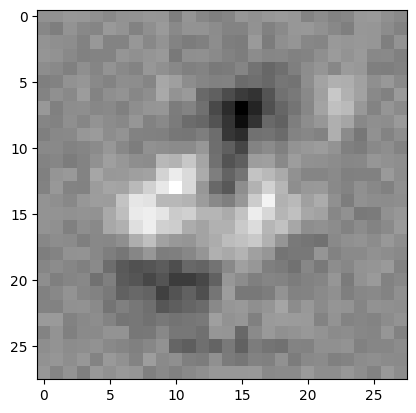

Época 72/100 - Perda: 0.3108 - Acurácia: 0.9280
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


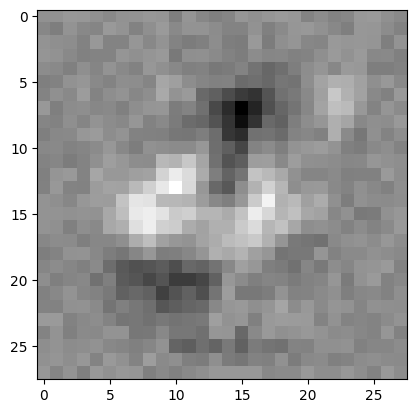

Época 73/100 - Perda: 0.3088 - Acurácia: 0.9280
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


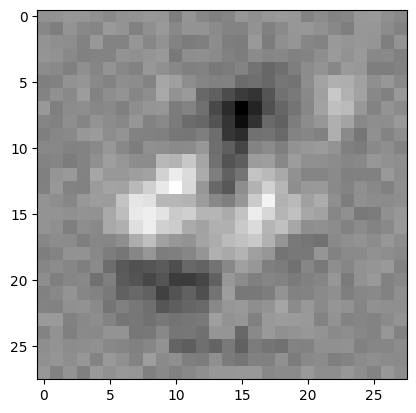

Época 74/100 - Perda: 0.3069 - Acurácia: 0.9300
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


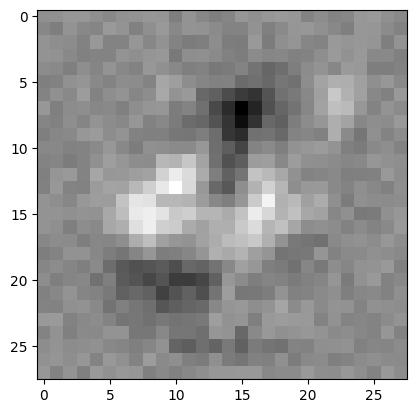

Época 75/100 - Perda: 0.3050 - Acurácia: 0.9310
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


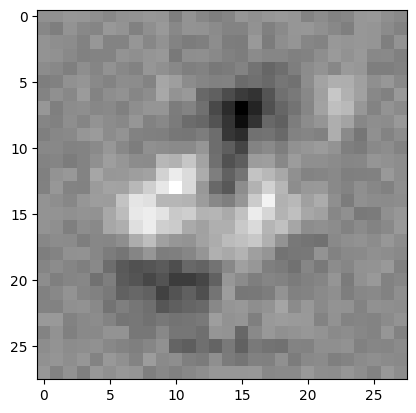

Época 76/100 - Perda: 0.3031 - Acurácia: 0.9310
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


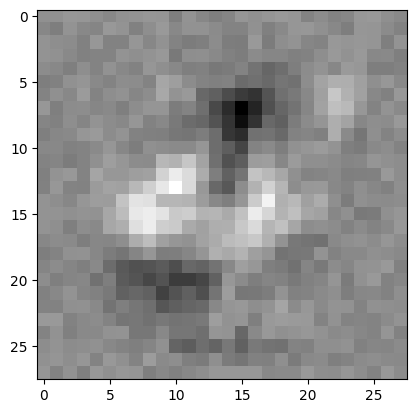

Época 77/100 - Perda: 0.3012 - Acurácia: 0.9320
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


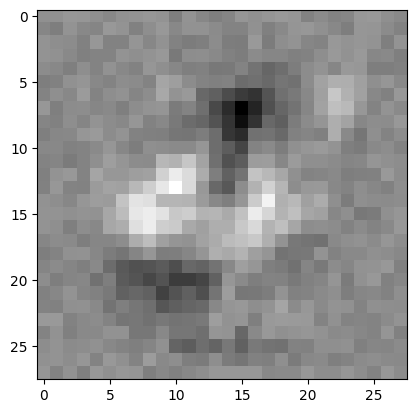

Época 78/100 - Perda: 0.2994 - Acurácia: 0.9320
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


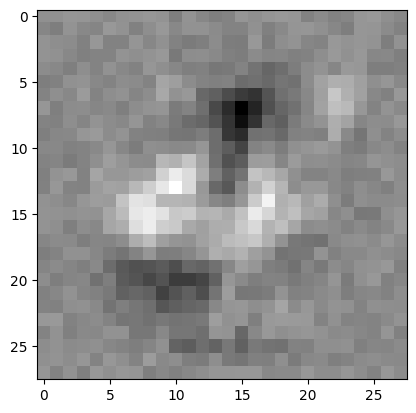

Época 79/100 - Perda: 0.2976 - Acurácia: 0.9330
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


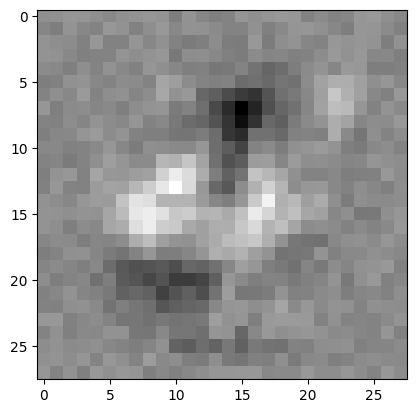

Época 80/100 - Perda: 0.2958 - Acurácia: 0.9330
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


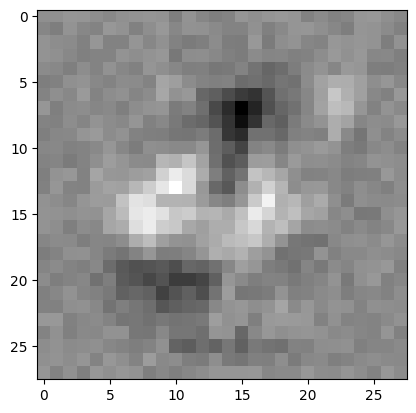

Época 81/100 - Perda: 0.2941 - Acurácia: 0.9330
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


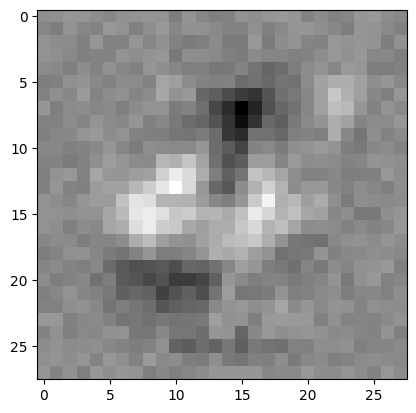

Época 82/100 - Perda: 0.2924 - Acurácia: 0.9330
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


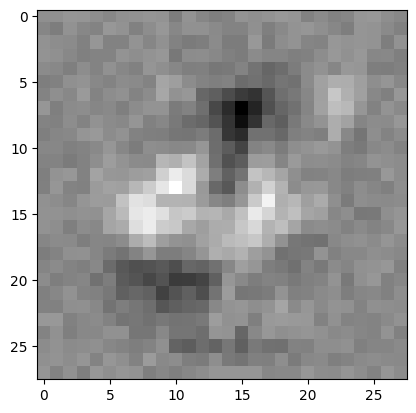

Época 83/100 - Perda: 0.2907 - Acurácia: 0.9340
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


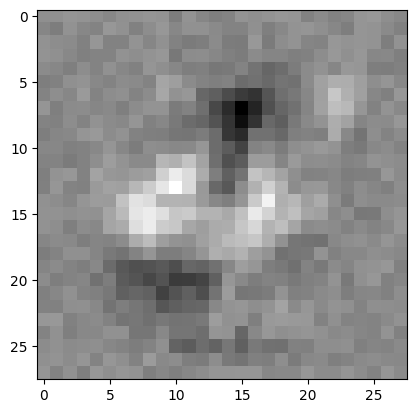

Época 84/100 - Perda: 0.2890 - Acurácia: 0.9350
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


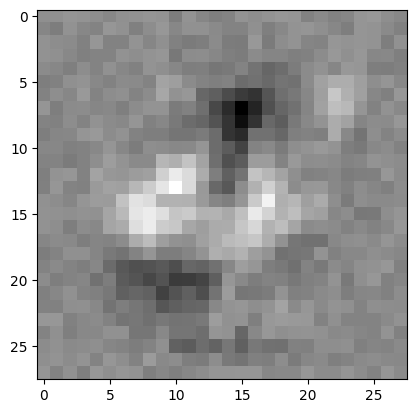

Época 85/100 - Perda: 0.2873 - Acurácia: 0.9350
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


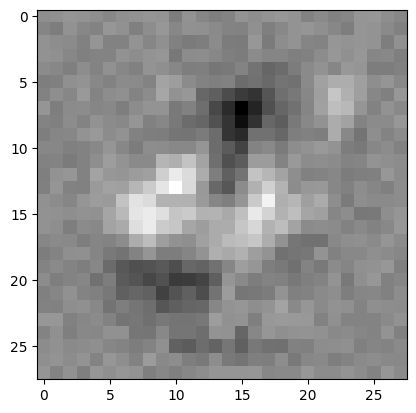

Época 86/100 - Perda: 0.2857 - Acurácia: 0.9350
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


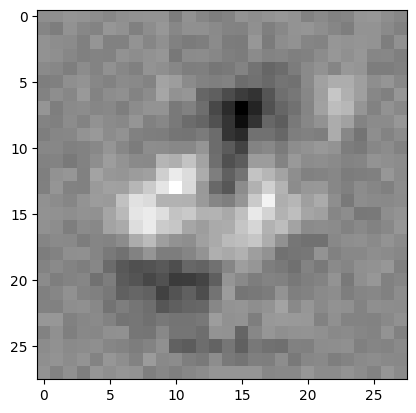

Época 87/100 - Perda: 0.2841 - Acurácia: 0.9350
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


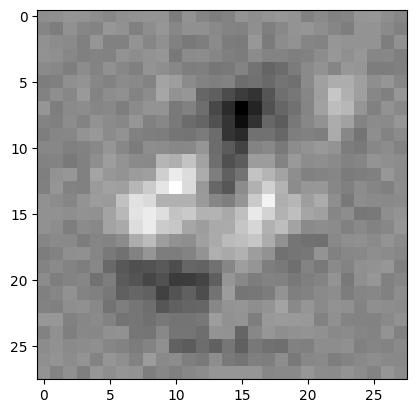

Época 88/100 - Perda: 0.2825 - Acurácia: 0.9350
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


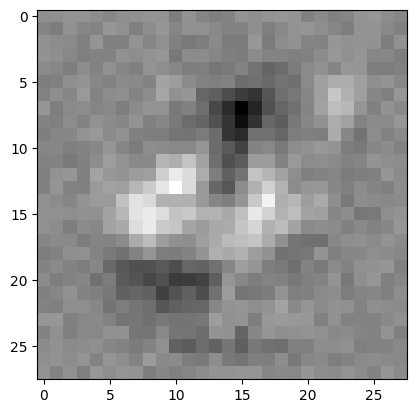

Época 89/100 - Perda: 0.2810 - Acurácia: 0.9350
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


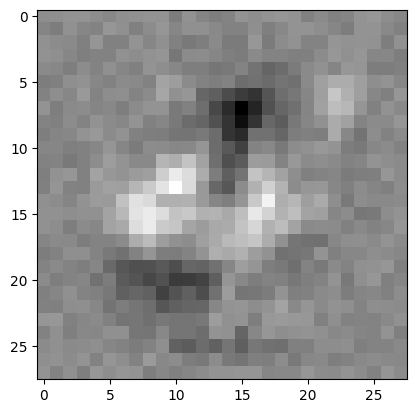

Época 90/100 - Perda: 0.2795 - Acurácia: 0.9350
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


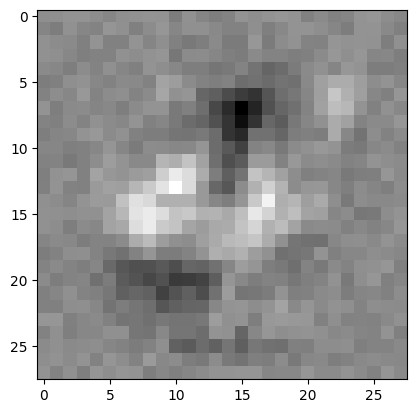

Época 91/100 - Perda: 0.2779 - Acurácia: 0.9350
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


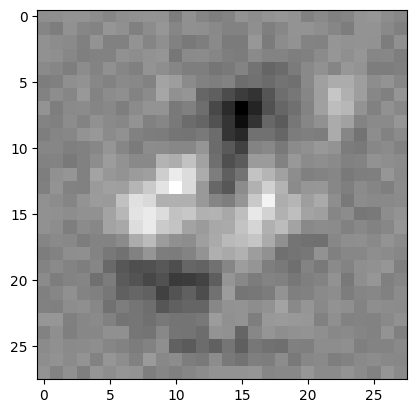

Época 92/100 - Perda: 0.2765 - Acurácia: 0.9350
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


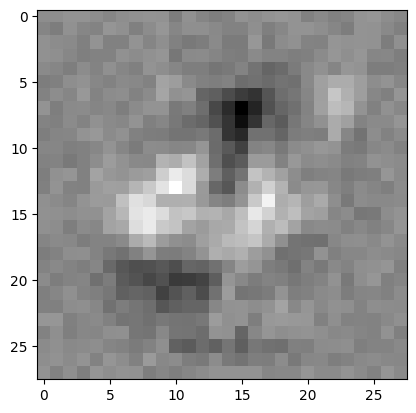

Época 93/100 - Perda: 0.2750 - Acurácia: 0.9350
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


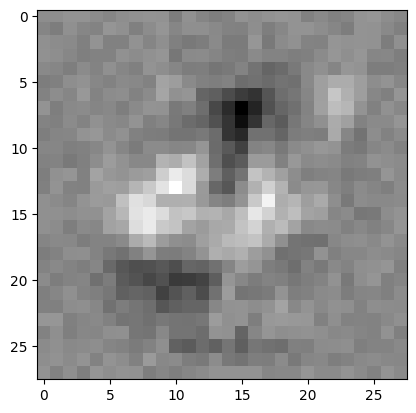

Época 94/100 - Perda: 0.2735 - Acurácia: 0.9350
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


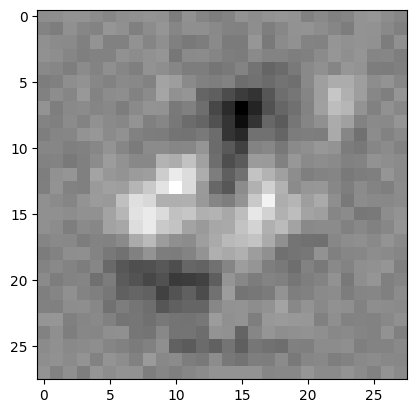

Época 95/100 - Perda: 0.2721 - Acurácia: 0.9350
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


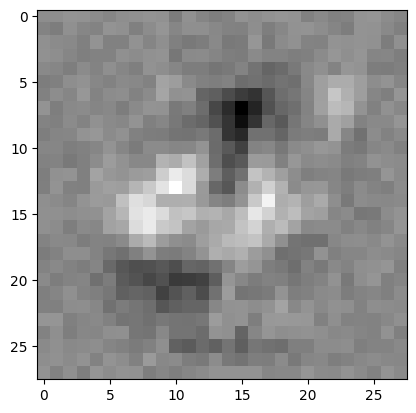

Época 96/100 - Perda: 0.2707 - Acurácia: 0.9350
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


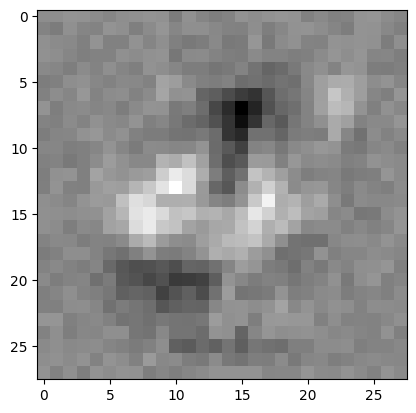

Época 97/100 - Perda: 0.2693 - Acurácia: 0.9360
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


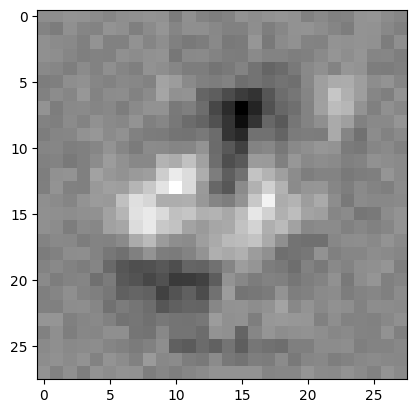

Época 98/100 - Perda: 0.2679 - Acurácia: 0.9370
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


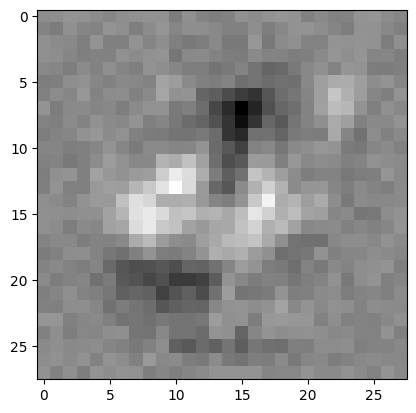

Época 99/100 - Perda: 0.2665 - Acurácia: 0.9370
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


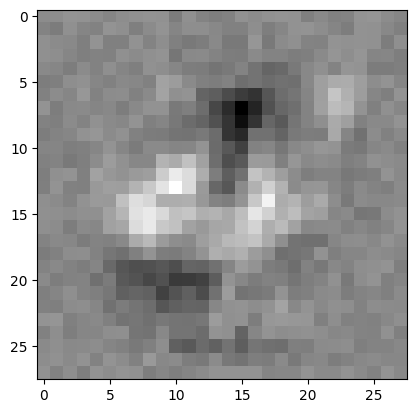

Época 100/100 - Perda: 0.2652 - Acurácia: 0.9380
Pesos: (10, 784)
Bias:  (10,)
<class 'numpy.ndarray'>


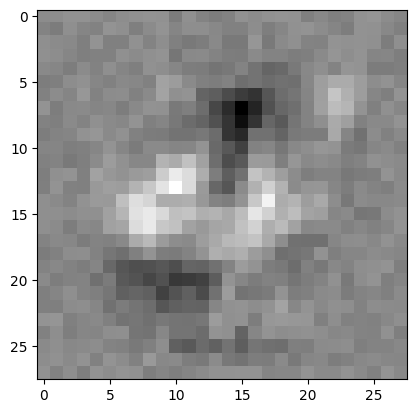

In [27]:
for epoch in train_metrics:
    print(f"Época {epoch.get('epoch')}/{qtd_epochs} - Perda: {epoch.get('loss'):.4f} - Acurácia: {epoch.get('accuracy'):.4f}")

    print('Pesos:', epoch.get('weights').shape)
    print('Bias: ', epoch.get('bias').shape)

    print(type(epoch.get('weights')))

    plt.imshow(epoch.get('weights')[4, :].reshape((28,28)),cmap = 'gray')
    plt.show()

<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

## Perguntas

1. Qual é o shape da matriz de entrada na rede?
    > R.: 1000, 784
2. Qual é o shape da saída da rede?
    > R.: 1000, 10
3. Qual é o número total de parâmetros da rede, incluindo o bias?
    > R.: 7850

# Aprendizados
